In [ ]:
!pip install pandas matplotlib

In [ ]:

import random, math, statistics, csv, os
from heapq import heappush, heappop
from collections import deque, defaultdict
import itertools
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline


def print_stats(d):
    for k,v in d.items():
        print(f"{k}: {v}")


In [ ]:

class Request:
    __slots__ = ("id","arrival","func","exec","start","finish","cold_start","served_by_inst")
    def __init__(self, req_id, arrival, func_id, exec_time):
        self.id = req_id
        self.arrival = arrival
        self.func = func_id
        self.exec = exec_time
        self.start = None
        self.finish = None
        self.cold_start = False
        self.served_by_inst = None


class Instance:
    __slots__ = ("id","func","state","free_time","busy_until")
    def __init__(self, inst_id, func_id):
        self.id = inst_id
        self.func = func_id
        self.state = 'idle'     # 'idle' | 'busy'
        self.free_time = 0.0
        self.busy_until = 0.0

class FunctionMeta:
    __slots__ = ("id","t_e","t_l","t_v","instances","queue")
    def __init__(self, func_id, t_e=1.0, t_l=1.0, t_v=1.0):
        self.id = func_id
        self.t_e = t_e
        self.t_l = t_l
        self.t_v = t_v
        self.instances = []   # list of Instance ids
        self.queue = deque()

# ---- Event constants ----
EV_ARRIVAL = 'arrival'
EV_FINISH  = 'finish'
EV_COLD_DONE = 'cold_done'

# ---- Simulator class ----
class Simulator:
    def __init__(self, capacity=16, seed=42, verbose=False, debug_frp=False, frp_debug_limit=200):
        self.C = capacity
        self.verbose = verbose
        self.debug_frp = debug_frp
        self.frp_debug_limit = frp_debug_limit
        self.time = 0.0
        self.ev_counter = itertools.count()
        self.ev_q = []
        self.requests = {}
        self.functions = {}
        self.instances = {}
        self.next_req_id = 1
        self.next_inst_id = 1
        self.random = random.Random(seed)
        self.cold_starts = 0
        self.evictions = 0
        self.replacements = 0
        self.per_req_log = []
        self.frp_log = []   

    def push_event(self, time, ev_type, payload):
        heappush(self.ev_q, (time, next(self.ev_counter), ev_type, payload))
    def pop_event(self):
        return heappop(self.ev_q) if self.ev_q else None

    def total_instances_count(self):
        return len(self.instances)
    def instances_of_func(self, func_id):
        fm = self.functions[func_id]
        return [self.instances[iid] for iid in fm.instances]

    def idle_instance_of(self, func_id):
        for iid in self.functions[func_id].instances:
            inst = self.instances[iid]
            if inst.state == 'idle':
                return inst
        return None

    def find_candidate_idle_funcs(self):
        return [fid for fid,fm in self.functions.items() if any(self.instances[i].state=='idle' for i in fm.instances)]

    def compute_ne_j(self, nw_j, t_lj, Kj_count, t_ej):
        if t_ej == 0: return float('-inf')
        return nw_j + 1.0 - (t_lj * Kj_count) / t_ej

    def compute_ne_j_jprime(self, nw_j, t_lj, t_vjprime, Kj_count, t_ej):
        if t_ej == 0: return float('-inf')
        return nw_j + 1.0 - ((t_lj + t_vjprime) * Kj_count) / t_ej

    def compute_wj_for_frp(self, t_ej, t_vj, Kj_count, nw_j):
        if Kj_count <= 0 or nw_j <= 0:
            return float('inf')
        return t_ej + (t_vj / Kj_count) / nw_j

    def compute_wjprime_for_candidate(self, t_ejp, t_ljp, t_vjp, Kj_count, ne_jprime_j):
        if ne_jprime_j <= 0:
            return float('inf')
        return t_ejp + (t_ljp + t_vjp) * (Kj_count + 1.0) / ne_jprime_j

    def create_instance(self, now, func_id, cold=True):
        inst = Instance(self.next_inst_id, func_id)
        self.next_inst_id += 1
        inst.state = 'cold' if cold else 'idle'
        self.instances[inst.id] = inst
        self.functions[func_id].instances.append(inst.id)
        return inst

    def evict_instance(self, now, inst):
        if inst.id not in self.instances: return
        fm = self.functions[inst.func]
        try:
            fm.instances.remove(inst.id)
        except ValueError:
            pass
        del self.instances[inst.id]
        self.evictions += 1

    def start_service_on_instance(self, now, inst, req):
        inst.state = 'busy'
        inst.busy_until = now + req.exec
        req.start = now
        req.finish = inst.busy_until
        req.served_by_inst = inst.id
        self.push_event(inst.busy_until, EV_FINISH, (inst.id, req.id))

    # arrival handler (FCP)
    def handle_arrival(self, now, req):
        fm = self.functions[req.func]
        nw_j = len(fm.queue)
        idle = self.idle_instance_of(req.func)
        if nw_j == 0 and idle:
            self.start_service_on_instance(now, idle, req)
            return
        currK = len(fm.instances)
        if self.total_instances_count() < self.C:
            ne_j = self.compute_ne_j(nw_j, fm.t_l, currK, fm.t_e)
            if ne_j > 0:
                inst = self.create_instance(now, req.func, cold=True)
                cold_done_t = now + fm.t_l
                req.cold_start = True
                self.cold_starts += 1
                self.push_event(cold_done_t, EV_COLD_DONE, (inst.id, req.id))
                return

        if self.total_instances_count() >= self.C:
            candidate = [] # S List
            idle_funcs = self.find_candidate_idle_funcs()
            for fj in idle_funcs:
                fj_meta = self.functions[fj]
                Kj_count = len(fj_meta.instances)
                ne = self.compute_ne_j_jprime(nw_j, fm.t_l, fj_meta.t_v, Kj_count, fm.t_e)
                if ne > 0:
                    candidate.append((fj, fj_meta))
            if candidate:
                chosen_fj, chosen_meta = max(candidate, key=lambda x: x[1].t_e)
                inst_to_replace = None
                for iid in chosen_meta.instances:
                    if self.instances[iid].state == 'idle':
                        inst_to_replace = self.instances[iid]; break
                if inst_to_replace:
                    evict_time = now + chosen_meta.t_v
                    self.evict_instance(now, inst_to_replace)
                    self.replacements += 1
                    ready_time = evict_time + fm.t_l
                    inst_new = self.create_instance(now, req.func, cold=True)
                    req.cold_start = True
                    self.cold_starts += 1
                    self.push_event(ready_time, EV_COLD_DONE, (inst_new.id, req.id))
                    return

        fm.queue.append(req)
        return

    # finish handler (FRP)
    def handle_finish(self, now, inst_id, req_id):
        if inst_id not in self.instances:
            return
        inst = self.instances[inst_id]
        fm = self.functions[inst.func]
        nw_j = len(fm.queue)
        Kj_count = len(fm.instances)

        if nw_j > 0 and Kj_count > 0:
            wj = fm.t_e + (fm.t_v * Kj_count/ nw_j)
        else:
            wj = float('inf')

        candidates = [] # S List
        for fj, fj_meta in self.functions.items():
            if len(fj_meta.queue) <= 0:
                continue
            Kj_prime = len(fj_meta.instances)
            nw_jprime = len(fj_meta.queue)
            if fj_meta.t_e > 0:
                ne = nw_jprime + 1.0 - ((fj_meta.t_l + fm.t_v) * Kj_prime) / fj_meta.t_e
            else:
                ne = -1  

            if ne <= 0:
                continue

            K_current = Kj_count
            wjp = fj_meta.t_e + ((fj_meta.t_l + fj_meta.t_v) * (K_current + 1.0)) / ne

            candidates.append((fj, fj_meta, ne, wjp))

        chosen = None
        if candidates:
            chosen = min(candidates, key=lambda x: x[3])  
            chosen_fid, chosen_meta, ne_ch, wj_ch = chosen
        else:
            chosen_fid = None
            wj_ch = None

        if self.debug_frp and len(self.frp_log) < self.frp_debug_limit:
            log_entry = {
                "time": now,
                "inst_id": inst_id,
                "curr_func": inst.func,
                "nw_j": nw_j,
                "Kj": Kj_count,
                "w_j": wj,
                "candidates": [
                    {
                        "func": fj,
                        "nw": len(fj_meta.queue),
                        "Kj": len(fj_meta.instances),
                        "ne_jprime_j": ne,
                        "w_jprime": wjp,
                    }
                    for (fj, fj_meta, ne, wjp) in candidates
                ],
                "chosen_func": chosen_fid if chosen_fid is not None else inst.func,
                "chosen_w": (wj_ch if chosen_fid is not None else wj),
            }
            self.frp_log.append(log_entry)

            print(f"[FRP] t={now:.3f}, curr={inst.func}, w_j={wj:.4f}, nw_j={nw_j}, Kj={Kj_count}")
            for c in log_entry["candidates"]:
                print(f"   cand={c['func']}, nw={c['nw']}, Kj={c['Kj']}, ne={c['ne_jprime_j']:.3f}, w'={c['w_jprime']:.4f}")
            print(f"   -> chosen: {log_entry['chosen_func']} (w*={log_entry['chosen_w']:.4f})")

        do_replace = False
        if candidates and wj_ch is not None and wj_ch < wj:
            do_replace = True

        if do_replace:
            self.evict_instance(now, inst)
            self.replacements += 1
            ready_t = now + fm.t_v + self.functions[chosen_fid].t_l
            new_inst = self.create_instance(now, chosen_fid, cold=True)
            self.push_event(ready_t, EV_COLD_DONE, (new_inst.id, None))
            return

        if len(fm.queue) > 0:
            next_req = fm.queue.popleft()
            self.start_service_on_instance(now, inst, next_req)
        else:
            inst.state = 'idle'
            inst.free_time = now

    def handle_cold_done(self, now, inst_id, pinned_req_id):
        if inst_id not in self.instances:
            return
        inst = self.instances[inst_id]
        inst.state = 'idle'
        inst.free_time = now
        if pinned_req_id is not None:
            req = self.requests[pinned_req_id]
            req.cold_start = True
            self.start_service_on_instance(now, inst, req)
            return
        fm = self.functions[inst.func]
        if len(fm.queue) > 0:
            next_req = fm.queue.popleft()
            next_req.cold_start = True
            self.start_service_on_instance(now, inst, next_req)
            return

    def run(self):
        while self.ev_q:
            t, _, ev_type, payload = self.pop_event()
            self.time = t
            if ev_type == EV_ARRIVAL:
                req = payload
                self.handle_arrival(t, req)
            elif ev_type == EV_FINISH:
                inst_id, req_id = payload
                req = self.requests.get(req_id)
                if req:
                    self.per_req_log.append((req.id, req.arrival, req.start, req.finish, req.func, req.exec, req.cold_start))
                self.handle_finish(t, inst_id, req_id)
            elif ev_type == EV_COLD_DONE:
                inst_id, pinned_req_id = payload
                self.handle_cold_done(t, inst_id, pinned_req_id)
            else:
                pass

    def submit_requests(self, req_list):
        for req in req_list:
            self.requests[req.id] = req
            self.push_event(req.arrival, EV_ARRIVAL, req)

    def summarize(self):
        if not self.per_req_log:
            return {}
        latencies = [(fi - arr) for (r,arr,st,fi,fu,ex,c) in self.per_req_log if st is not None and fi is not None]
        if not latencies:
            return {}
        avg_resp = statistics.mean(latencies)
        p50 = statistics.quantiles(latencies, n=100)[49]
        p95 = statistics.quantiles(latencies, n=100)[94]
        p99 = statistics.quantiles(latencies, n=100)[98]
        cold_count = sum(1 for (_,_,_,_,_,_,c) in self.per_req_log if c)
        stats = {
            "requests": len(self.per_req_log),
            "avg_response": avg_resp,
            "p50": p50, "p95": p95, "p99": p99,
            "cold_starts": cold_count,
            "replacements": self.replacements,
            "evictions": self.evictions
        }
        return stats

In [ ]:

def synthetic_workload(duration=600, rate=5.0, num_funcs=50, zipf_param=1.2, seed=0):
    rnd = random.Random(seed)
    funcs = [f"f{idx}" for idx in range(1, num_funcs+1)]
    ranks = list(range(1, num_funcs+1))
    weights = [1.0/(r**zipf_param) for r in ranks]
    s = sum(weights)
    probs = [w/s for w in weights]
    func_mean = {f: max(0.005, rnd.lognormvariate(math.log(0.1), 1.0)) for f in funcs}
    t = 0.0
    reqs = []
    req_id = 1
    while t < duration:
        u = rnd.random()
        if u == 0: u = 1e-12
        inter = -math.log(u) / rate
        t += inter
        if t > duration: break
        fid = rnd.choices(funcs, probs)[0]
        mu = math.log(max(1e-3, func_mean[fid]))
        ex = max(0.001, rnd.lognormvariate(mu, 0.9))
        reqs.append(Request(req_id, t, fid, ex))
        req_id += 1
    return reqs, func_mean

def build_functions_from_reqs(reqs, default_tl=(0.5,1.5), default_tv=(0.5,1.5), seed=123):
    rnd = random.Random(seed)
    per_func_execs = defaultdict(list)
    for r in reqs:
        per_func_execs[r.func].append(r.exec)
    func_map = {}
    for fid, exs in per_func_execs.items():
        mean_ex = statistics.mean(exs) if exs else 0.1
        tl = rnd.uniform(*default_tl)
        tv = rnd.uniform(*default_tv)
        func_map[fid] = FunctionMeta(fid, t_e=mean_ex, t_l=tl, t_v=tv)
    return func_map

def load_trace_csv(path, max_reqs=None):
    rows = []
    with open(path, 'r', newline='') as f:
        reader = csv.DictReader(f)
        for r in reader:
            rows.append(r)
            if max_reqs and len(rows) >= max_reqs:
                break
    recs = []
    t0 = None
    for i,r in enumerate(rows):
        a = None
        for col in ('arrival','timestamp','time','ts','start','start_time'):
            if col in r and r[col] not in (None,''):
                try:
                    a = float(r[col])
                    break
                except:
                    pass
        fid = None
        for col in ('func','function','fname','function_id','id'):
            if col in r and r[col] not in (None,''):
                fid = r[col]; break
        ex = None
        for col in ('exec','duration','dur','runtime','execution'):
            if col in r and r[col] not in (None,''):
                try:
                    ex = float(r[col]); break
                except:
                    pass
        if a is None or fid is None or ex is None:
            continue
        if i == 0: t0 = a
        arr = a - t0
        if ex == 0: ex = 0.001
        recs.append((arr, str(fid), ex))
    reqs = []
    for i,(arr,fid,ex) in enumerate(recs, start=1):
        reqs.append(Request(i, arr, fid, ex))
    return reqs


In [ ]:
# Create synthetic workload and run the simulator
duration = 300.0   # seconds
rate = 10.0        # avg requests / sec
num_funcs = 80
C = 16
seed = 123

reqs, func_mean = synthetic_workload(duration=duration, rate=rate, num_funcs=num_funcs, seed=seed)
func_metas = build_functions_from_reqs(reqs, seed=seed)

sim = Simulator(capacity=C, seed=seed, verbose=False)
sim.functions = func_metas
sim.submit_requests(reqs)
sim.run()

stats = sim.summarize()
print("Simulation stats (synthetic):")
print_stats(stats)

df = pd.DataFrame(sim.per_req_log, columns=["req_id","arrival","start","finish","func","exec","cold"])
# compute latency column
df["latency"] = df["finish"] - df["arrival"]
df.head(8)


Simulation stats (synthetic):
requests: 3012
avg_response: 2.0761917185654553
p50: 1.9419750072565876
p95: 4.364242246444232
p99: 8.865021907832006
cold_starts: 1257
replacements: 1248
evictions: 1248


,req_id,arrival,start,finish,func,exec,cold,latency
0,1,0.019869,0.572233,0.662714,f2,0.090482,True,0.642845
1,2,0.075464,0.982705,0.996630,f60,0.013925,True,0.921166
2,8,0.633875,1.379038,1.390033,f69,0.010995,True,0.756159
3,6,0.564795,1.402012,1.414205,f79,0.012194,True,0.849410
4,4,0.244960,1.281162,1.437106,f4,0.155944,True,1.192146
5,16,1.406663,1.437106,1.473254,f4,0.036148,False,0.066591
6,5,0.249580,1.601666,1.768561,f1,0.166894,True,1.518981
7,9,0.671273,1.768561,1.821499,f1,0.052938,False,1.150226


P50: 1.9414861584400285
P95: 4.343569709482409
P99: 8.772403309227315


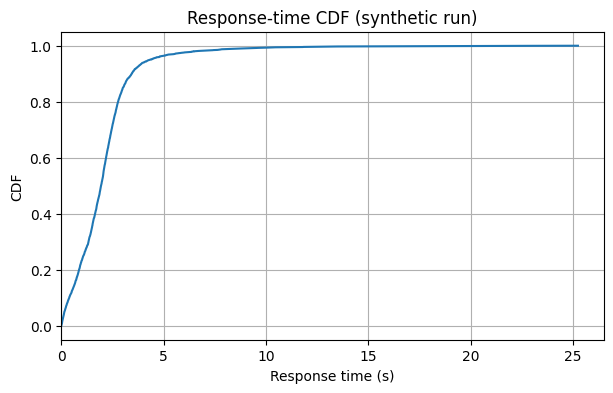

In [ ]:
# Plot CDF of latencies and show P50/P95/P99
lat = df["latency"].dropna().values
lat_sorted = sorted(lat)
n = len(lat_sorted)
xs = lat_sorted
ys = [(i+1)/n for i in range(n)]

plt.figure(figsize=(7,4))
plt.plot(xs, ys)
plt.xlabel("Response time (s)")
plt.ylabel("CDF")
plt.title("Response-time CDF (synthetic run)")
plt.grid(True)
plt.xlim(left=0)

# percentiles
def percentile(arr, p):
    k = int(math.ceil((p/100.0) * len(arr))) - 1
    k = max(0, min(k, len(arr)-1))
    return arr[k]

print("P50:", percentile(lat_sorted, 50))
print("P95:", percentile(lat_sorted, 95))
print("P99:", percentile(lat_sorted, 99))


In [ ]:
ls

sample_data/


In [ ]:
!ls

sample_data


In [ ]:
!git clone https://github.com/Azure/AzurePublicDataset.git

Cloning into 'AzurePublicDataset'...
remote: Enumerating objects: 3817, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 3817 (delta 94), reused 84 (delta 72), pack-reused 3688 (from 1)
Receiving objects: 100% (3817/3817), 105.75 MiB | 12.87 MiB/s, done.
Resolving deltas: 100% (303/303), done.
Updating files: 100% (858/858), done.


In [ ]:
!sudo apt-get install unrar -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
!ls

AzurePublicDataset  sample_data


In [ ]:
!cd AzurePublicDataset/

In [ ]:
!ls

AzurePublicDataset  sample_data


In [ ]:
cd AzurePublicDataset

/content/AzurePublicDataset


In [ ]:
ls

analysis/                             AzurePublicDatasetV1.md
AzureFunctionsBlobDataset2020.md      AzurePublicDatasetV2.md
AzureFunctionsDataset2019.md*         AzureTracesForPacking2020.md
AzureFunctionsInvocationTrace2021.md  AzureVMNoiseDataset2024.md
AzureGreenSKUFramework2023.md         data/
AzureLLMInferenceDataset2023.md       LICENSE
AzureLLMInferenceDataset2024.md       LICENSE-CODE
AzureLMMInferenceDataset2025.md       README.md
AzurePublicDatasetLinksV2.txt         SECURITY.md
AzurePublicDatasetV1Links.txt         vm-noise-data/


In [ ]:
cd data

/content/AzurePublicDataset/data


In [ ]:
!unrar x AzureFunctionsInvocationTraceForTwoWeeksJan2021.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from AzureFunctionsInvocationTraceForTwoWeeksJan2021.rar

Extracting  AzureFunctionsInvocationTraceForTwoWeeksJan2021.txt           22% 45% 68% 90%100%  OK 
All OK


In [ ]:
cd ../..

/content


In [ ]:
TRACE_PATH = "./AzurePublicDataset/data/AzureFunctionsInvocationTraceForTwoWeeksJan2021.txt"
reqs = load_trace_csv(TRACE_PATH, max_reqs=200000)
func_metas = build_functions_from_reqs(reqs)
sim = Simulator(capacity=16, seed=123, verbose=False)
sim.functions = func_metas
sim.submit_requests(reqs)
sim.run()
print_stats(sim.summarize())

In [ ]:
print(sim.summarize())

{}


In [ ]:

out_csv = "results_esff.csv"
df.to_csv(out_csv, index=False)
print(f"Wrote per-request results to {out_csv}")


agg = df.groupby("func").agg(requests=("req_id","count"), avg_latency=("latency","mean"), cold_frac=("cold","mean"))
agg_sorted = agg.sort_values("requests", ascending=False)
agg_sorted.head(10)


Wrote per-request results to results_esff.csv


,requests,avg_latency,cold_frac
func,,,
f1,850,1.622623,0.082353
f2,388,1.241844,0.250000
f3,217,2.265172,0.239631
f4,139,1.810237,0.438849
f5,139,1.654660,0.438849
f6,98,2.165965,0.510204
f7,71,2.357498,0.507042
f8,70,2.866104,0.485714
f9,69,2.014813,0.478261


In [ ]:
ls

AzurePublicDataset/  results_esff.csv  sample_data/


In [ ]:
cd ./AzurePublicDataset/data/

/content/AzurePublicDataset/data


In [ ]:
with open("AzureFunctionsInvocationTraceForTwoWeeksJan2021.txt") as f:
    for _ in range(20):
        print(f.readline().rstrip())


app,func,end_timestamp,duration
7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de05270735055950a568,e3cdb48830f66eb8689cc0223514569a69812b77e6611e3d59814fac0747bd2f,0.07949090003967285,0.078
1573b95c039e51cc012b543a4af3bc7c3ee9485acbb0033ba5648b74969e0556,337cd24a7d5fd5c92460faee4ebe6a186a0eb322bd17b73da7ffa153025794e1,57.15786004066467,57.154
1573b95c039e51cc012b543a4af3bc7c3ee9485acbb0033ba5648b74969e0556,48cc770d590d3c5a7691b3b4e9302f82ec3be5ddc2a037d94ad2e76f44dd8946,59.13047790527344,59.125
f274d71de386ccc77e4ca74766dbc485461c3053059d47266463c45ec92001b3,3d2aee54a133509f16fb636d74128c2adcfcac71c6dcef78fda1ace004f2ab47,6.2525410652160645,6.236
7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de05270735055950a568,68bbfd828223a505d7917339f4656c5f33ff93225cdb9d0fcbc9889edb49253a,0.06682395935058594,0.05
f7bfe5bc8d2a37a5c15986fbfc2c477a746e866adcb9663f9df7535b61c3eb9b,34f4775366e51728635af48df1a96d332cf1565eee069a0030f12966ae760274,0.0999910831451416,0.078
85479ef37b5dc75dd5aeca3bab499129b97a1

In [ ]:

src = "AzureFunctionsInvocationTraceForTwoWeeksJan2021.txt"
N = 30
with open(src, "r") as f:
    for i in range(N):
        line = f.readline()
        if not line:
            break
        print(line.rstrip())


app,func,end_timestamp,duration
7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de05270735055950a568,e3cdb48830f66eb8689cc0223514569a69812b77e6611e3d59814fac0747bd2f,0.07949090003967285,0.078
1573b95c039e51cc012b543a4af3bc7c3ee9485acbb0033ba5648b74969e0556,337cd24a7d5fd5c92460faee4ebe6a186a0eb322bd17b73da7ffa153025794e1,57.15786004066467,57.154
1573b95c039e51cc012b543a4af3bc7c3ee9485acbb0033ba5648b74969e0556,48cc770d590d3c5a7691b3b4e9302f82ec3be5ddc2a037d94ad2e76f44dd8946,59.13047790527344,59.125
f274d71de386ccc77e4ca74766dbc485461c3053059d47266463c45ec92001b3,3d2aee54a133509f16fb636d74128c2adcfcac71c6dcef78fda1ace004f2ab47,6.2525410652160645,6.236
7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de05270735055950a568,68bbfd828223a505d7917339f4656c5f33ff93225cdb9d0fcbc9889edb49253a,0.06682395935058594,0.05
f7bfe5bc8d2a37a5c15986fbfc2c477a746e866adcb9663f9df7535b61c3eb9b,34f4775366e51728635af48df1a96d332cf1565eee069a0030f12966ae760274,0.0999910831451416,0.078
85479ef37b5dc75dd5aeca3bab499129b97a1

Wrote 200000 rows to azure_trace_esff_ready_full.csv so far...
Wrote 400000 rows to azure_trace_esff_ready_full.csv so far...
Wrote 600000 rows to azure_trace_esff_ready_full.csv so far...
Wrote 800000 rows to azure_trace_esff_ready_full.csv so far...
Wrote 1000000 rows to azure_trace_esff_ready_full.csv so far...
Wrote 1200000 rows to azure_trace_esff_ready_full.csv so far...
Wrote 1400000 rows to azure_trace_esff_ready_full.csv so far...
Wrote 1600000 rows to azure_trace_esff_ready_full.csv so far...
Wrote 1800000 rows to azure_trace_esff_ready_full.csv so far...
Wrote 1980951 rows to azure_trace_esff_ready_full.csv so far...
Full normalized CSV written: azure_trace_esff_ready_full.csv
Loading normalized CSV for sorting (may take memory)...
Rows before sort: 1980951
Rows after sort: 1980951
Sorted ESFF-ready CSV written: azure_trace_esff_ready_sorted.csv
count    1.980951e+06
mean     5.663548e+05
std      3.518260e+05
min      1.490900e-03
25%      2.497272e+05
50%      5.039977e+05

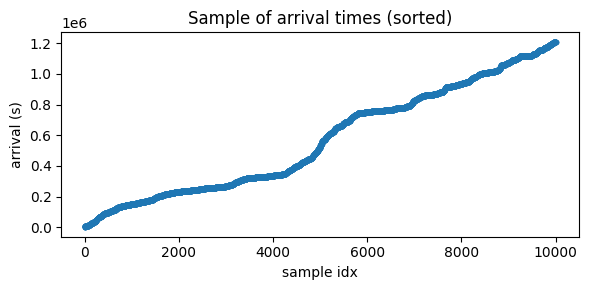

In [ ]:

import pandas as pd
import os
from pathlib import Path

SRC = "AzureFunctionsInvocationTraceForTwoWeeksJan2021.txt"   
OUT_FULL = "azure_trace_esff_ready_full.csv"
OUT_SORTED = "azure_trace_esff_ready_sorted.csv"
CHUNKSIZE = 200_000     

first = True
written = 0
for chunk in pd.read_csv(SRC, chunksize=CHUNKSIZE):
    for col in ("end_timestamp","duration","func"):
        if col not in chunk.columns:
            raise RuntimeError(f"Expected column '{col}' not found in chunk; columns={chunk.columns.tolist()}")
    chunk = chunk.copy()
    chunk["arrival"] = chunk["end_timestamp"] - chunk["duration"]
    neg = (chunk["arrival"] < 0).sum()
    if neg:
        print(f"Warning: dropping {neg} rows with arrival < 0 in this chunk")
        chunk = chunk[chunk["arrival"] >= 0]
    chunk["exec"] = chunk["duration"]   
    chunk["func"] = chunk["func"].astype(str)
    out_chunk = chunk[["arrival","func","exec"]]
    if first:
        out_chunk.to_csv(OUT_FULL, index=False, mode="w")
        first = False
    else:
        out_chunk.to_csv(OUT_FULL, index=False, header=False, mode="a")
    written += len(out_chunk)
    print(f"Wrote {written} rows to {OUT_FULL} so far...")

print("Full normalized CSV written:", OUT_FULL)

print("Loading normalized CSV for sorting (may take memory)...")
df = pd.read_csv(OUT_FULL)
print("Rows before sort:", len(df))
df = df.sort_values("arrival").reset_index(drop=True)
print("Rows after sort:", len(df))
df.to_csv(OUT_SORTED, index=False)
print("Sorted ESFF-ready CSV written:", OUT_SORTED)

print(df["arrival"].describe())
print("exec describe:", df["exec"].describe())
import matplotlib.pyplot as plt
sample = df["arrival"].sample(min(10000, len(df)), random_state=1).sort_values()
plt.figure(figsize=(6,3))
plt.plot(sample.values, ".")
plt.title("Sample of arrival times (sorted)")
plt.xlabel("sample idx")
plt.ylabel("arrival (s)")
plt.tight_layout()
plt.show()

In [ ]:

TRACE_CSV = "azure_trace_esff_ready_sorted.csv"
df_small = pd.read_csv(TRACE_CSV).head(200000)
df_small.to_csv("azure_trace_small.csv", index=False)

reqs = load_trace_csv("azure_trace_small.csv", max_reqs=None)
func_metas = build_functions_from_reqs(reqs, default_tl=(0.5,1.5), default_tv=(0.5,1.5), seed=123)

sim_dbg = Simulator(capacity=4, seed=42, debug_frp=True, frp_debug_limit=15)
sim_dbg.functions = func_metas
sim_dbg.submit_requests(reqs)
sim_dbg.run()

print("FRP events logged:", len(sim_dbg.frp_log))

[FRP] t=0.630, curr=e3cdb48830f66eb8689cc0223514569a69812b77e6611e3d59814fac0747bd2f, w_j=inf, nw_j=0, Kj=1
   cand=68bbfd828223a505d7917339f4656c5f33ff93225cdb9d0fcbc9889edb49253a, nw=1, Kj=0, ne=2.000, w'=2.2598
   cand=34f4775366e51728635af48df1a96d332cf1565eee069a0030f12966ae760274, nw=1, Kj=0, ne=2.000, w'=1.7476
   cand=49535532e285d1ef68b0a7b8c3bc3973b36ec38a4c594ec9f1412084c27036ff, nw=1, Kj=0, ne=2.000, w'=1.5333
   cand=e6df36937abcf1f6d0be4f2e3ffd12d98717dd6f29a9cd233790506517888daf, nw=1, Kj=0, ne=2.000, w'=2.6951
   cand=cd9f7f333d59aede8088772edac3bff78c45e2dad8eb498b450b9af511452a36, nw=1, Kj=0, ne=2.000, w'=80.9638
   cand=e02465de583b6ceffa5b78cce5f10eb27e714a8a6b3aed483be50f30a924071f, nw=1, Kj=0, ne=2.000, w'=2.1548
   cand=4a4146ed669e9c0bdb2c7db94558df4ec44bf31ec5609d066408de4a4215efbd, nw=1, Kj=0, ne=2.000, w'=3.1764
   cand=514a9bcff07d21b5580057748e55e78bb062e3001a01b75b497939d5378cc78c, nw=1, Kj=0, ne=2.000, w'=3.5427
   cand=ebfe951bf36afd91115e54adab000c6325a

In [ ]:
ls

AzureFunctionsInvocationTraceForTwoWeeksJan2021.rar
AzureFunctionsInvocationTraceForTwoWeeksJan2021.txt
AzureLLMInferenceTrace_code.csv
AzureLLMInferenceTrace_conv.csv
AzureLMMInferenceTrace_multimodal.csv.gz
azure_trace_esff_ready_full.csv
azure_trace_esff_ready_sorted.csv
azure_trace_small.csv


In [ ]:
import pandas as pd

TRACE_CSV = "azure_trace_esff_ready_sorted.csv"

MAX_REQS = 200_000  

base_df = pd.read_csv(TRACE_CSV).head(MAX_REQS)
print("Using rows:", len(base_df))

print("Arrival range:", base_df['arrival'].min(), "->", base_df['arrival'].max())
print("Exec stats:\n", base_df['exec'].describe())


Using rows: 200000
Arrival range: 0.0014909000396727 -> 148331.16009497835
Exec stats:
 count    200000.000000
mean          4.412469
std          32.569968
min           0.000000
25%           0.001000
50%           0.001000
75%           0.234000
max         578.620000
Name: exec, dtype: float64


In [ ]:
import numpy as np

def run_esff_once(df, capacity, seed=42):
    reqs = []
    for idx, row in df.iterrows():
        reqs.append(Request(
            req_id=int(idx)+1,
            arrival=float(row["arrival"]),
            func_id=str(row["func"]),  
            exec_time=float(row["exec"])
        ))

    func_metas = build_functions_from_reqs(
        reqs,
        default_tl=(0.5, 1.5),   
        default_tv=(0.5, 1.5),
        seed=123
    )

    sim = Simulator(capacity=capacity, seed=seed, verbose=False)
    sim.functions = func_metas
    sim.submit_requests(reqs)
    sim.run()

    cols = ["req_id","arrival","start","finish","func","exec","cold"]
    df_res = pd.DataFrame(sim.per_req_log, columns=cols)

    df_res["resp"] = df_res["finish"] - df_res["arrival"]
    df_res["slowdown"] = df_res["resp"] / df_res["exec"].clip(lower=1e-6)

    avg_resp = df_res["resp"].mean()
    avg_slow = df_res["slowdown"].mean()

    cold_df = df_res[df_res["cold"] == True]
    total_cold_time = 0.0
    for func_id, group in cold_df.groupby("func"):
        meta = sim.functions[func_id]
        total_cold_time += len(group) * meta.t_l  

    avg_cold_per_req = total_cold_time / len(df_res)

    return {
        "C": capacity,
        "avg_response": avg_resp,
        "avg_slowdown": avg_slow,
        "avg_coldstart": avg_cold_per_req,
        "num_reqs": len(df_res),
        "sim": sim,        
        "df_res": df_res,  
    }

Running ESFF with capacity C=4...
Running ESFF with capacity C=8...
Running ESFF with capacity C=12...
Running ESFF with capacity C=16...
Running ESFF with capacity C=20...
Running ESFF with capacity C=24...
Running ESFF with capacity C=28...
Running ESFF with capacity C=32...
    C  avg_response   avg_slowdown  avg_coldstart
0   4   1748.043211  105412.036464       0.219940
1   8     41.334888   96157.470481       0.222762
2  12     18.895745   47968.392739       0.181428
3  16     14.534730   28213.706917       0.148988
4  20     12.295862   14933.835831       0.125838
5  24     10.721521   12530.761778       0.110471
6  28      9.042744    9505.794629       0.099349
7  32      8.075999   10170.809439       0.088400


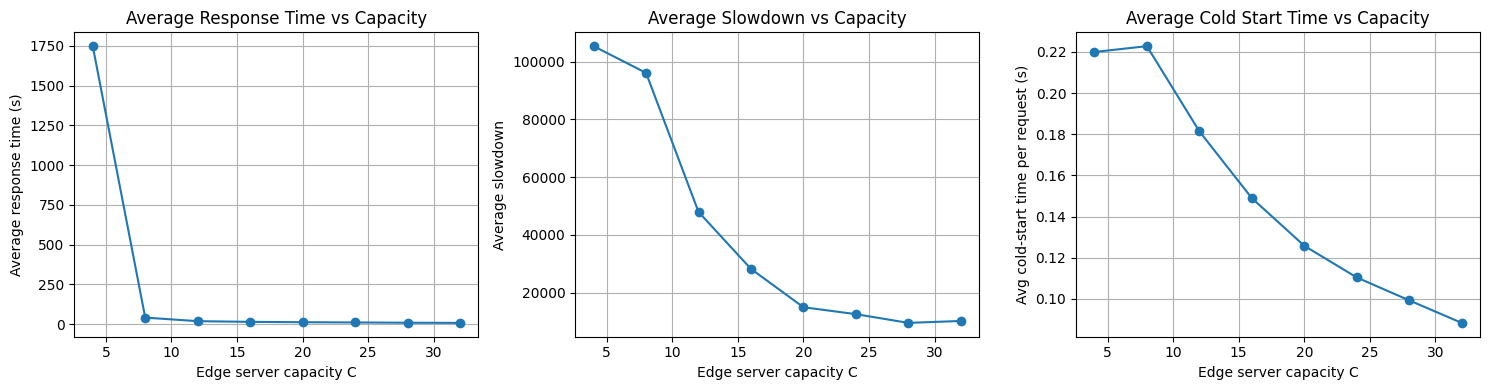

In [ ]:
import matplotlib.pyplot as plt

CAP_LIST = [4, 8, 12, 16, 20, 24, 28, 32]  

results_cap = []
for C in CAP_LIST:
    print(f"Running ESFF with capacity C={C}...")
    res = run_esff_once(base_df, capacity=C, seed=42)
    results_cap.append(res)

df_cap = pd.DataFrame(results_cap)
print(df_cap[["C","avg_response","avg_slowdown","avg_coldstart"]])


plt.figure(figsize=(15,4))

# (a) Average Response Time
plt.subplot(1,3,1)
plt.plot(df_cap["C"], df_cap["avg_response"], marker="o")
plt.xlabel("Edge server capacity C")
plt.ylabel("Average response time (s)")
plt.title("Average Response Time vs Capacity")
plt.grid(True)

# (b) Average Slowdown
plt.subplot(1,3,2)
plt.plot(df_cap["C"], df_cap["avg_slowdown"], marker="o")
plt.xlabel("Edge server capacity C")
plt.ylabel("Average slowdown")
plt.title("Average Slowdown vs Capacity")
plt.grid(True)

# (c) Average Cold Start Time
plt.subplot(1,3,3)
plt.plot(df_cap["C"], df_cap["avg_coldstart"], marker="o")
plt.xlabel("Edge server capacity C")
plt.ylabel("Avg cold-start time per request (s)")
plt.title("Average Cold Start Time vs Capacity")
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
def make_scaled_df(base_df, ratio):
    df_scaled = base_df.copy()
    df_scaled["arrival"] = df_scaled["arrival"] * ratio
    return df_scaled


Running ESFF with workload intensity ratio=1.0 (arrival scaled)...
Running ESFF with workload intensity ratio=1.1 (arrival scaled)...
Running ESFF with workload intensity ratio=1.2 (arrival scaled)...
Running ESFF with workload intensity ratio=1.3 (arrival scaled)...
Running ESFF with workload intensity ratio=1.4 (arrival scaled)...
   ratio  avg_response  avg_slowdown  avg_coldstart
0    1.0     14.534730  28213.706917       0.148988
1    1.1     14.900819  25223.800108       0.142147
2    1.2     15.252136  23691.678137       0.140143
3    1.3     15.870957  25450.904097       0.138895
4    1.4     15.890254  81972.460877       0.136523


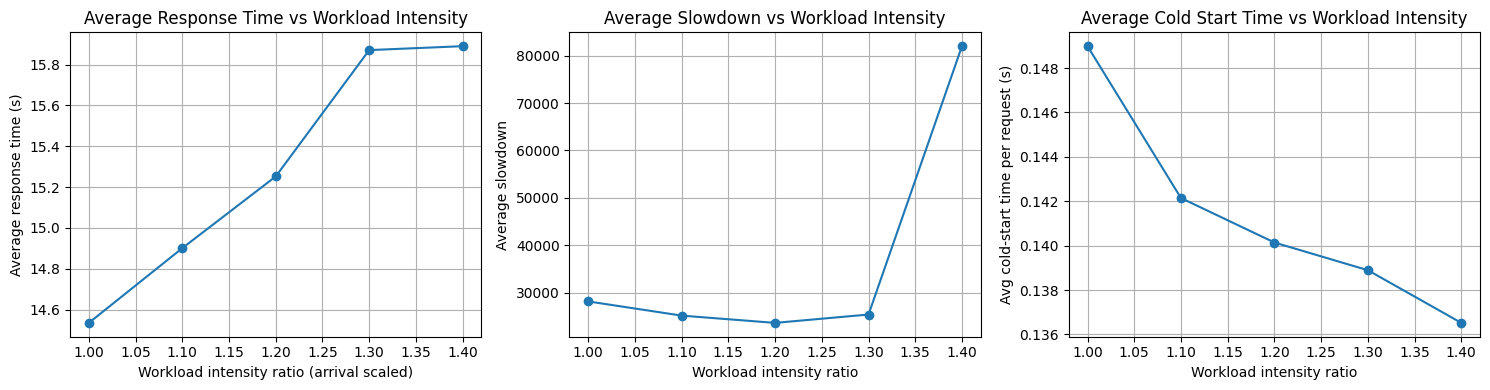

In [ ]:
# Fix capacity as in paper's default: C = 16
CAP_FIXED = 16

RATIOS = [1.0, 1.1, 1.2, 1.3, 1.4]

results_intensity = []
for r in RATIOS:
    print(f"Running ESFF with workload intensity ratio={r} (arrival scaled)...")
    df_scaled = make_scaled_df(base_df, r)
    res = run_esff_once(df_scaled, capacity=CAP_FIXED, seed=42)
    res["ratio"] = r
    results_intensity.append(res)

df_int = pd.DataFrame(results_intensity)
print(df_int[["ratio","avg_response","avg_slowdown","avg_coldstart"]])

plt.figure(figsize=(15,4))

# (a) Average Response Time
plt.subplot(1,3,1)
plt.plot(df_int["ratio"], df_int["avg_response"], marker="o")
plt.xlabel("Workload intensity ratio (arrival scaled)")
plt.ylabel("Average response time (s)")
plt.title("Average Response Time vs Workload Intensity")
plt.grid(True)

# (b) Average Slowdown
plt.subplot(1,3,2)
plt.plot(df_int["ratio"], df_int["avg_slowdown"], marker="o")
plt.xlabel("Workload intensity ratio")
plt.ylabel("Average slowdown")
plt.title("Average Slowdown vs Workload Intensity")
plt.grid(True)

# (c) Average Cold Start Time
plt.subplot(1,3,3)
plt.plot(df_int["ratio"], df_int["avg_coldstart"], marker="o")
plt.xlabel("Workload intensity ratio")
plt.ylabel("Avg cold-start time per request (s)")
plt.title("Average Cold Start Time vs Workload Intensity")
plt.grid(True)

plt.tight_layout()
plt.show()
